In [93]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt

In [215]:
torch.manual_seed(42)
dist = torch.distributions.Uniform(-3, 5)
data = dist.sample([4096, 2])
data = data[:]
data_mean, data_std = data.mean(dim=0), data.std(dim=0)
data_mean, data_std

(tensor([1.0331, 0.9544]), tensor([2.3134, 2.3027]))

In [174]:
class GhostBatchNorm(nn.Module):
    def __init__(self, n_in, virtual_bs, momentum=0.1, eps=1e-5):
        super().__init__()
        self.virtual_bs = virtual_bs
        self.eps = eps
        self.mm = momentum
        
        gamma = nn.Parameter(torch.ones(n_in))
        self.register_parameter("gamma", gamma)
        
        beta = nn.Parameter(torch.zeros(n_in))
        self.register_parameter("beta", beta)
        
        self.register_buffer("running_mean", torch.zeros(n_in))
        self.register_buffer("running_std", torch.ones(n_in))

    
    def forward(self, X): # X => (batch_size, num_features)
        # on inference use running values
        if not self.training:
            return self.gamma * (X - self.running_mean)/self.running_std + self.beta
        
        # obtain ghost batches
        num_ghost_batches = np.ceil(X.size(0)/self.virtual_bs).astype(int)
        ghost_batches = X.view(num_ghost_batches, self.virtual_bs, X.size(-1)) # (num_gb, virtual_bs, num_features)
        
        # obtain metrics
        ghost_mean = ghost_batches.mean(dim=1).unsqueeze(1) # (num_gb, 1, num_features)
        ghost_std = ghost_batches.std(dim=1).unsqueeze(1) # (num_gb, 1, num_features)
        
        # normalize
        normalized_ghost_batches = (ghost_batches - ghost_mean) / ghost_std
        normalized_batch = normalized_ghost_batches.view(X.size()) # (batch_size, num_features)
        
        # update running metrics
        self.running_mean = self._calculate_running_metric(
            self.running_mean, ghost_mean, num_ghost_batches) # (num_features)
        self.running_std = self._calculate_running_metric(
            self.running_std, ghost_std, num_ghost_batches) # (num_features)
        
        return self.gamma * normalized_batch + self.beta
    
    def _calculate_running_metric(self, running_metric, ghost_metric, num_ghost_batches):
        weighted_prev = ((1-self.mm)**num_ghost_batches) * running_metric
        
        exp_idxs = torch.arange(0, num_ghost_batches).flip(dims=(0,))
        weighted_new = (
            (self.mm * (1-self.mm)**exp_idxs)[..., None] * ghost_metric.squeeze(1)
        ).sum(dim=0)
        
        return weighted_prev + weighted_new
    

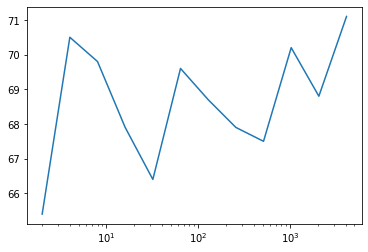

In [196]:
vbs = [2, 2**2, 2**3, 2**4, 2**5, 2**6, 128, 128*2**1, 128*2**2, 128*2**3, 128*2**4, 128*2**5]
vector = [65.4, 70.5, 69.8, 67.9, 66.4, 69.6, 68.7, 67.9, 67.5, 70.2, 68.8, 71.1]
plt.plot(vbs, vector)
plt.xscale("log")

In [203]:
n_in = 2
vbs = 32
eps = 1e-5
mm = momentum = 0.1

gbn = GhostBatchNorm(n_in, vbs, eps=eps, momentum=momentum)

In [204]:
import timeit

In [216]:
times = []
vbs = [2, 2**2, 2**3, 2**4, 2**5, 2**6, 128, 128*2**1, 128*2**2, 128*2**3, 128*2**4, 128*2**5]
for _vbs in vbs:
    gbn = GhostBatchNorm(n_in, _vbs, eps=eps, momentum=momentum)
    times.append(timeit.timeit("for i in range(100): gbn(data)", number=1, globals=globals()))

In [217]:
times

[0.22704806900583208,
 0.13551873099640943,
 0.1289502510044258,
 0.0954140750109218,
 0.08185006698477082,
 0.07613838498946279,
 0.07152166799642146,
 0.06456645202706568,
 0.06378582399338484,
 0.06619077999494039,
 0.06473807999282144,
 0.06242851202841848]

In [192]:
b = nn.BatchNorm1d(2)

In [218]:
def smart(b, data, vbs):
    chunks = data.chunk(int(np.ceil(data.size()[0] / vbs)), 0)
    res = [b(x_) for x_ in chunks]

    return torch.cat(res, dim=0)


smart_times = []
vbs = [2, 2**2, 2**3, 2**4, 2**5, 2**6, 128, 128*2**1, 128*2**2, 128*2**3, 128*2**4, 128*2**5]
for _vbs in vbs:
    b = nn.BatchNorm1d(n_in)
    smart_times.append(timeit.timeit("for i in range(100): smart(b, data, _vbs)", number=1, globals=globals()))
smart_times

[11.756628635019297,
 5.7125585390022025,
 3.2123139100149274,
 1.426821100001689,
 0.7314507039845921,
 0.36317164299543947,
 0.20194202300626785,
 0.09771323500899598,
 0.05615514298551716,
 0.03516146700712852,
 0.022342740994645283,
 0.015567405993351713]

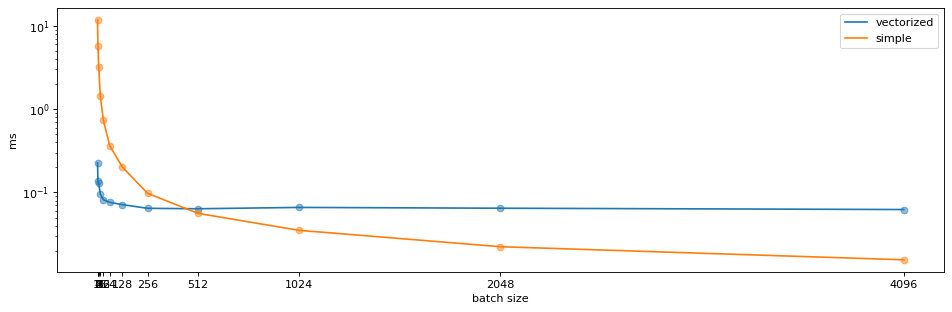

In [224]:
##### vbs = [2, 2**2, 2**3, 2**4, 2**5, 2**6, 128, 128*2**1, 128*2**2, 128*2**3, 128*2**4, 128*2**5]
plt.figure(figsize=(12,4), dpi=80)
plt.plot(vbs, times, label="vectorized")
plt.plot(vbs, times, "C0o", alpha=0.5)
plt.plot(vbs, smart_times, label="simple")
plt.plot(vbs, smart_times, "C1o", alpha=0.5)
#plt.xscale("log")
plt.yscale("log")
plt.ylabel("ms")
plt.xlabel("batch size")
plt.xticks(vbs)
plt.title("")
plt.legend()
plt.tight_layout()

In [ ]:
b.running_mean

In [12]:
b2 = nn.BatchNorm1d(2, momentum=0.1, eps=1e-5)

In [13]:
%time for i in range(100): b2(data)

CPU times: user 17.1 ms, sys: 1.59 ms, total: 18.7 ms
Wall time: 19.6 ms


In [14]:
b2.running_mean

tensor([1.0330, 0.9544])

In [23]:
g = GBN(n_in, vbs, eps=eps, momentum=momentum, metric_dim=1)
o = g(data)

b2 = nn.BatchNorm1d(2, momentum=0.1, eps=1e-5)
o2 = b2(data)
0

0